<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Text_Summarization_by_Fine_Tuning_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

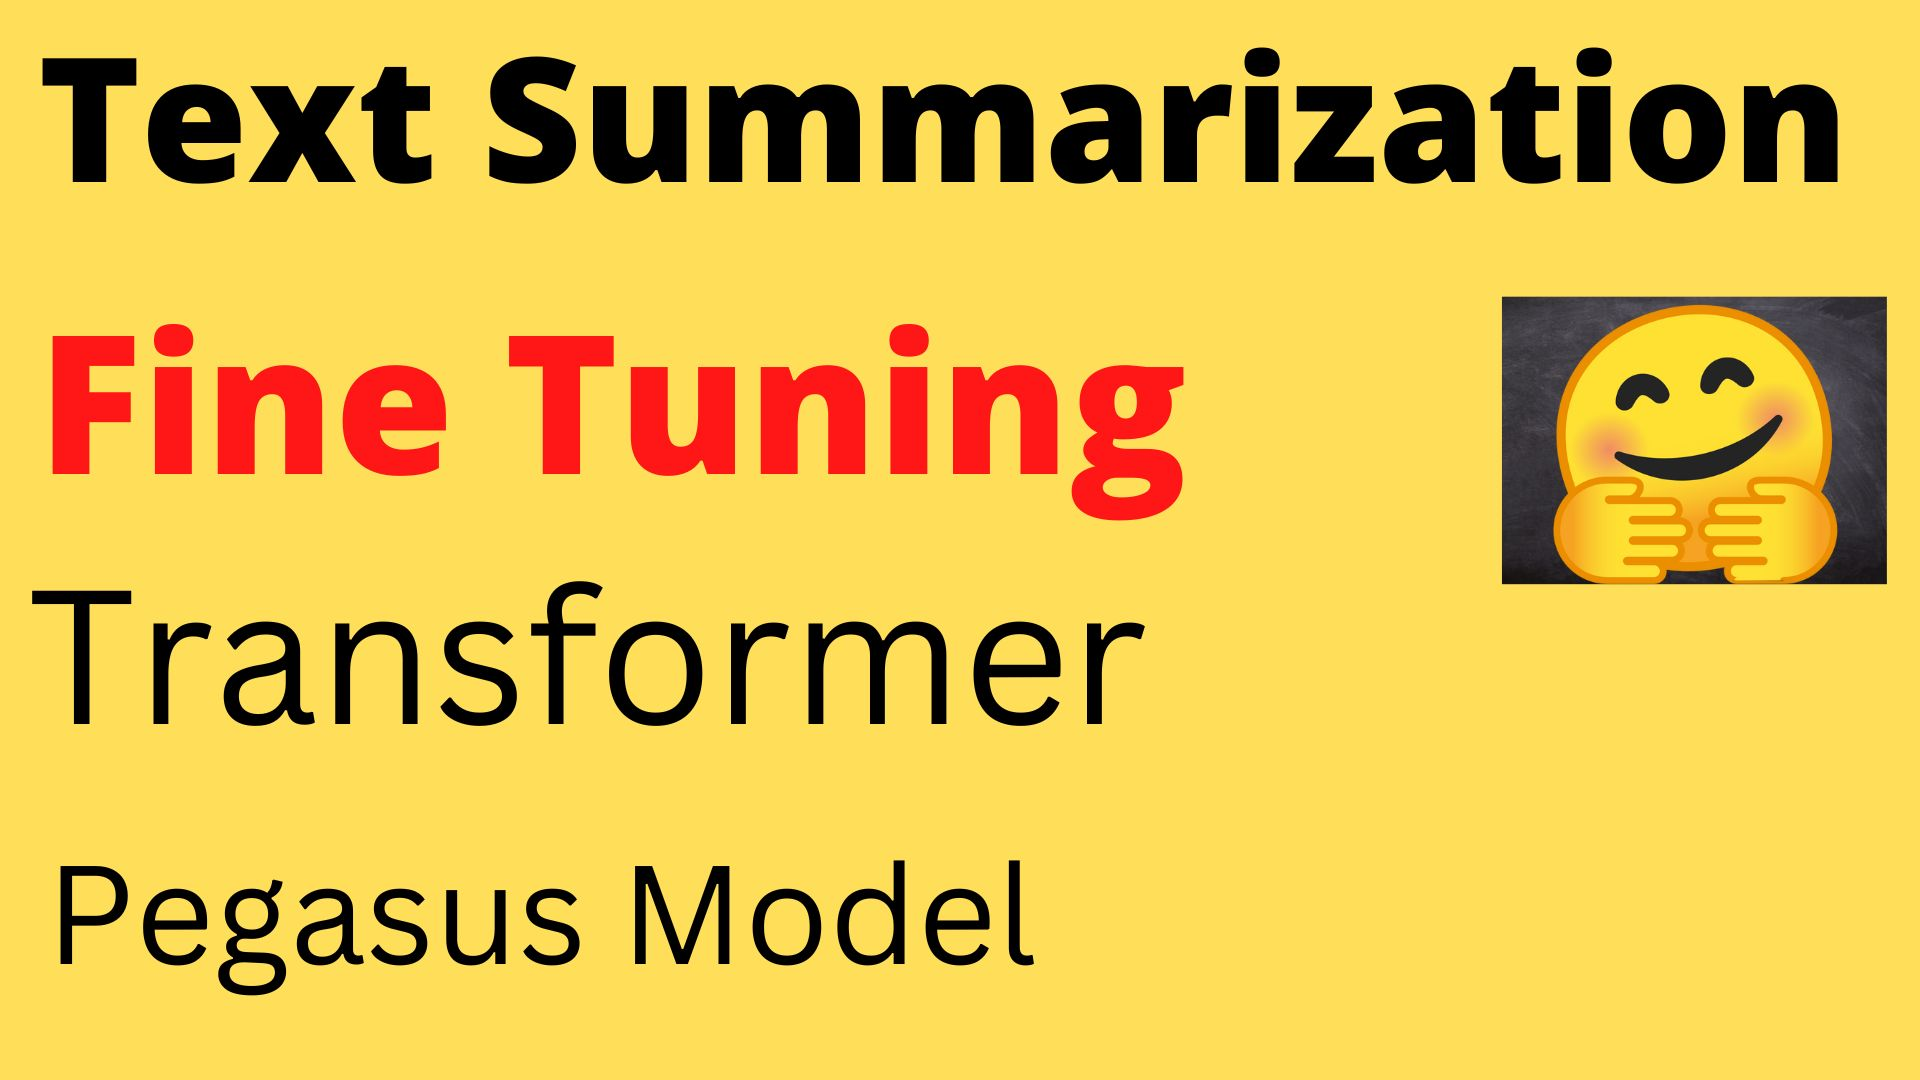

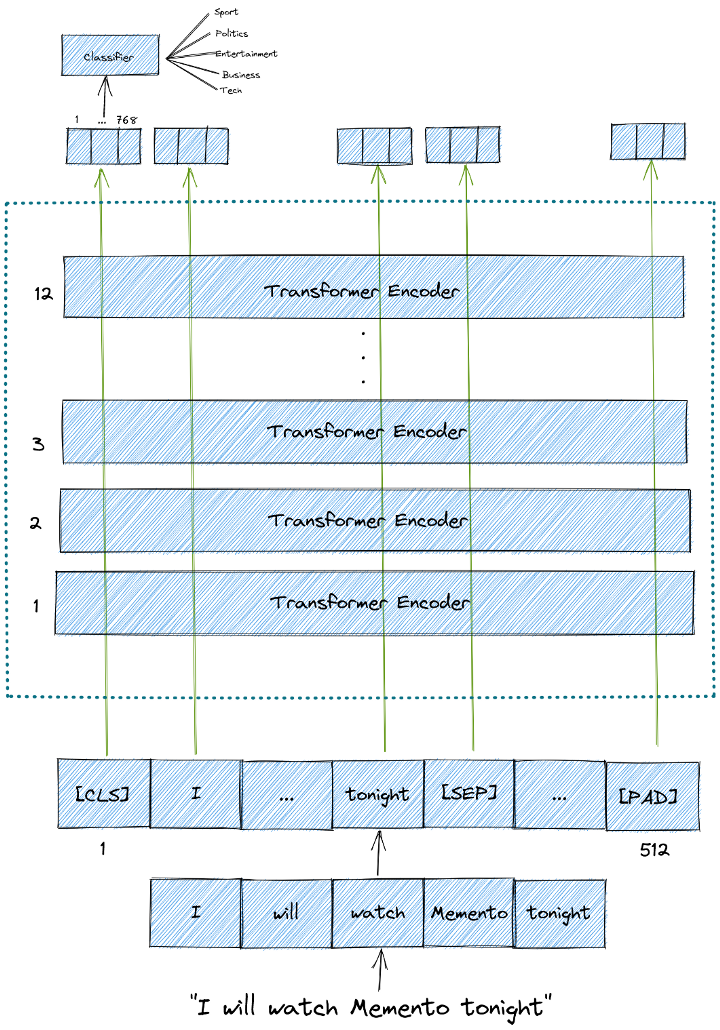

* **For a text classification task**, we focus our attention on the embedding vector output from the special **[CLS] token**. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

In [ ]:
!pip install transformers sentencepiece datasets sacrebleu rouge_score py7zr -q

     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 1.3 MB 70.3 MB/s 
     |████████████████████████████████| 452 kB 74.6 MB/s 
     |████████████████████████████████| 118 kB 83.5 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 29.6 MB/s 
     |████████████████████████████████| 182 kB 77.9 MB/s 
     |████████████████████████████████| 132 kB 78.6 MB/s 
     |████████████████████████████████| 213 kB 78.6 MB/s 
     |████████████████████████████████| 127 kB 86.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 378 kB 78.7 MB/s 
     |████████████████████████████████| 2.3 MB 28.4 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 357 kB 80.6 MB/s 
     |████████████████████████████████| 139 kB 85.8 MB/s 


In [ ]:
from transformers import pipeline,set_seed
import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

##Load Dataset

In [ ]:
dataset_samsum = load_dataset("samsum",split='train')

In [ ]:
dataset = dataset_samsum.train_test_split(test_size=0.1)
dataset.keys()

dict_keys(['train', 'test'])

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
print(f"Features: {dataset['train'].column_names}")
print("\nDialogue:")

print(dataset["test"][0]["dialogue"])

print("\nSummary:")

print(dataset["test"][0]["summary"])

Features: ['id', 'dialogue', 'summary']

Dialogue:
Mark: I still don't understand why they let him go.
Kevin: You're still not over that?
Mark: Well, he was my favorite player on the team.
Kevin: That was basically the last time they could get a decent price for him.
Kevin: His contract was going to end next year.
Mark: Money is not everything and without him the team will be a mess.
Kevin: It's not the first time they show that money is more important to them than results.
Mark: I know but that doesn't mean that I'm okay with it.

Summary:
Mark is upset that the team he supports sold his favourite player. He thinks that it will not succeed without him.


In [ ]:
 from torch.utils.data import DataLoader
 article_batches = DataLoader(test_dataset['dialogue'],batch_size=8)
 target_batches = DataLoader(test_dataset['summary'], batch_size=8)

In [ ]:
next(iter(article_batches))

["Noah: I'm going to Ulla tonight, would you fancy going to her school, too? \nMuhammad: I'd love to, I'm tired with Finn's yoga after the weekend workshops.\nNoah: Me too, totally!\nMuhammad: So, at 5.30 pm at the corner as usual?\nNoah: Yeah, see you there! \nMuhammad: See you! ",
 'Benjamin: <file_video>\r\nNathan: what a freak!\r\nBenjamin: my little bro\r\nNathan: wtf?!',
 "Janet: Jack I need to leave to see the doctor\r\nJack: I should be back in one hour\r\nJanet: that's too late for me\r\nJanet: I'll ask Mrs Peabody to take a look at the kids\r\nJack: I guess we have no other option\r\nJanet: Mia is doing her homework right now, Bob is playing and Rosie is finishing her exercises\r\nJack: <file_gif>\r\nJanet: dinner is in the oven \r\nJanet: I go and fetch Mrs Peabody\r\nJack: Ok, see you later!\r\nJanet: <file_gif>",
 'Sandra: Hi, im in the capital until tomorrow noon, fancy a coffee?\r\nMel: Hey! Sure! I will try to rip myself outa work :D when exactly do u have togo?\r\nSand

In [ ]:
import gc
gc.collect()

3

In [ ]:
def calculate_metric_on_test_ds(article_batches,target_batches, metric, model, tokenizer,device=device):

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        gc.collect()
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score 

In [11]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(article_batches,target_batches, rouge_metric, model_pegasus, tokenizer,device)

<ipython-input-11-dc594d23d794>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
100%|██████████| 185/185 [11:22:48<00:00, 221.45s/it]


In [12]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015161,0.000185,0.015109,0.015082


## Histogram

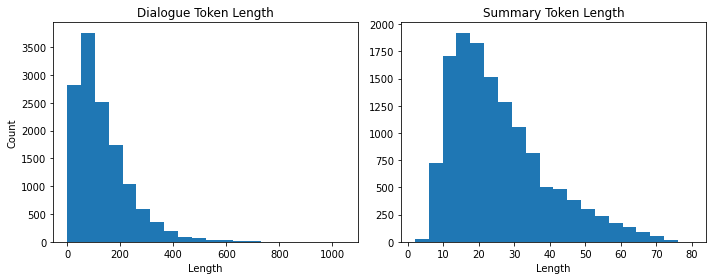

In [15]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in train_dataset['dialogue'] ]

summary_token_len = [len(tokenizer.encode(s)) for s in train_dataset['summary'] ]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20)
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20)
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [16]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
train_dataset_samsum_pt = train_dataset.map(convert_examples_to_features, batched = True)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [21]:
train_dataset_samsum_pt = train_dataset.map(convert_examples_to_features, batched = True)

  0%|          | 0/14 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [22]:
val_dataset_samsum_pt = test_dataset.map(convert_examples_to_features, batched = True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [18]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [23]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_dataset_samsum_pt, 
                  eval_dataset=val_dataset_samsum_pt)

In [ ]:
trainer.train()

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: id, summary, dialogue. If id, summary, dialogue are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13258
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 828
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

Step,Training Loss,Validation Loss


## Generating Dialogue Summaries

In [25]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}



sample_text = test_dataset[0]["dialogue"]

reference = test_dataset[0]["summary"]

pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

## 
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--pegasus-samsum/snapshots/f00170164d55821831b9396cc3da176af59f30ec/config.json
Model config PegasusConfig {
  "_name_or_path": "transformersbook/pegasus-samsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

KeyboardInterrupt: ignored